# Information Maximising GAN (InfoGAN)

InfoGAN: Interpretable Representation Learning by
Information Maximizing Generative Adversarial Nets - [paper](https://arxiv.org/pdf/1606.03657)

InfoGAN is an information-theoretic extension to GANs that learns disentangled representations in a completely unsupervised manner. InfoGAN maximises the mutual information between a fixed subset of the noise vector and the observations.

Mutual Information (I) = Entropy(c) - Entropy(c; G(z,c))

$\min\limits_G\max\limits_D V_I(D,G) = V(D,G) - \lambda I(c; G(z,c))$

Ref: https://aiden.nibali.org/blog/2016-12-01-implementing-infogan/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import tensorflow as tf

def plot_data(X, y):
    """Plot 2D or 3D according to X dimension."""
    if X.shape[1] == 1:
        for i in range(y.shape[1]):
            plt.plot(X, y[:,i], '.')
            plt.show()
    if X.shape[1] == 2:
        for i in range(y.shape[1]):
            ax = plt.axes(projection='3d')
            ax.scatter(X[:,0], X[:,1], y[:,i], c=y[:,i], cmap='viridis')
            plt.show()
            
def get_normal_data(n=1000, plot=False, xy_features=(2,1)):
    """Get normal dataset of x=(n*4,2), y=(n*4,1)."""
    x0 = np.concatenate([
        np.random.normal(10, 2, size=n),
        np.random.normal(10, 2, size=n),
        np.random.normal(20, 2, size=n),
        np.random.normal(20, 2, size=n),
    ])
    x1 = np.concatenate([
        np.random.normal(30, 2, size=n),
        np.random.normal(40, 2, size=n),
        np.random.normal(30, 2, size=n),
        np.random.normal(40, 2, size=n),
    ])
    y = np.concatenate([
        np.random.normal(50, 2, size=n),
        np.random.normal(60, 2, size=n),
        np.random.normal(70, 2, size=n),
        np.random.normal(80, 2, size=n),
    ])
    data = np.stack((x0, x1, y), axis=1).astype(np.float32)
    np.random.shuffle(data)
    
    if plot:
        ax = plt.axes(projection='3d')
        ax.scatter(data[:,0], data[:,1], data[:,2], alpha=0.3, c='r')
        plt.show()
    
    return (data[:,:2], np.expand_dims(data[:,2], axis=1)) \
            if xy_features == (2,1) else \
            (np.expand_dims(data[:,0], axis=1), data[:,1:])

X, y shapes: (4000, 2) (4000, 1)


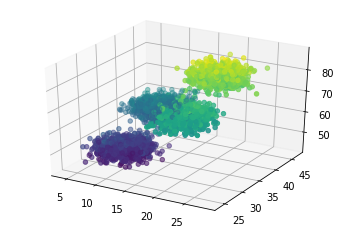

In [2]:
# Use normal dataset
n = 1000
X, y = get_normal_data(n, xy_features=(2,1))
print("X, y shapes:", X.shape, y.shape)

# Plot 2D or 3D graph according to X dimension
plot_data(X, y)

# Convert to TF dataset
n = len(X)
batch_size = 32
dataset = tf.data.Dataset \
    .from_tensor_slices((X,y)) \
    .shuffle(n).batch(batch_size)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy

class InfoGAN:
    def __init__(self, x_features, y_features):
        self.x_features = x_features
        self.y_features = y_features
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
    
    def build_generator(self):
        noise = Input(shape=(self.latent_dim,))  # noise
        c = Input(shape=(self.control_dim,))  # control
        h = Concatenate()([noise, c])
        h = Dense(16)(h)
        y = Dense(self.y_features)(h)
        return Model([noise, c], y)
    
    def build_discriminator(self):
        y = Input(shape=(self.y_features))
        d_y = Dense(16)(y)
        p = Dense(1, activation='sigmoid')(d_y)
        c_hat = Dense(1)(d_y)
        return Model(y, [p, c_hat])
    
    @tf.function
    def train_step(self):
        noise = tf.random.normal((self.batch_size, self.latent_dim))
        c = 